In [1]:
import gc
import numpy as np
import pandas as pd
import json
import argparse
import logging
import boto3
import atexit
import torch
import shutil
import os, errno, time, sys
import ipywidgets as widgets

from sqlalchemy import create_engine
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import interactive
interactive(True)
import mpldatacursor
import scipy.stats as sts
import scipy as sc
import seaborn as sns
import datetime
from datetime import timedelta
import urllib.parse
from urllib.parse import urlparse

from torch.cuda import is_available
from catboost import CatBoostClassifier, Pool, cv
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from bayes_opt import BayesianOptimization
from datetime import datetime, timedelta
from trains import logger
import operator
import re
import seaborn as sn
import copy

from matplotlib.patches import Patch
np.random.seed(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

import shap

In [2]:
local_dir = '/home/octopus/projects/sandbox/easytech/'
filename = 'Clinets_for_VIP.csv'
df = pd.read_csv(local_dir+filename,low_memory=False)

In [3]:

df['FirstRegistrationDate-ts'] = pd.to_datetime(df['FirstRegistrationDate'],  format = '%Y-%m-%d %H:%M:%S')
df['FirstDespositDate-ts'] = pd.to_datetime(df['FirstDepositDate'],  format = '%Y-%m-%d %H:%M:%S')
df['DemoRegistrationDate-ts'] = pd.to_datetime(df['DemoRegistrationDate'],  format = '%Y-%m-%d %H:%M:%S')
df['RealRegistrationDate-ts'] = pd.to_datetime(df['RealRegistrationDate'],  format = '%Y-%m-%d %H:%M:%S')
df['LastLoginDate-ts'] = pd.to_datetime(df['LastLoginDate'],  format = '%Y-%m-%d %H:%M:%S')
df['LastCommentDate-ts'] =  pd.to_datetime(df['LastCommentDate'],  format = '%Y-%m-%d %H:%M:%S')
df['reg_day_of_week'] = df['FirstRegistrationDate-ts'].dt.dayofweek
df['hour_of_reg'] = df['FirstRegistrationDate-ts'].dt.hour

df['lastCommentDays'] = (df['LastCommentDate-ts'] - df['FirstRegistrationDate-ts']).dt.days
df['lastLoginDays'] = (df['LastCommentDate-ts'] - df['FirstRegistrationDate-ts']).dt.days
df['Demmodays'] = (df['RealRegistrationDate-ts'] - df['DemoRegistrationDate-ts']).dt.days

In [4]:
df['ReferrerHost'] = df['Referrer'].apply(lambda x: urlparse(x).hostname  if type(x) is str else str(x))
df['ReferrerP1'] = df['Referrer'].apply(lambda x: urlparse(x).path.split('/')[1]  if type(x) is str and len( urlparse(x).path.split('/')) > 1  else "unknown-p1")
df['ReferrerP2'] = df['Referrer'].apply(lambda x: urlparse(x).path.split('/')[2]  if type(x) is str and len(urlparse(x).path.split('/')) > 2 else "unknown-p2")
df['ReferrerP3'] = df['Referrer'].apply(lambda x: urlparse(x).path.split('/')[3]  if type(x) is str and len(urlparse(x).path.split('/')) > 3  else "unknown-p3")
df['ReferrerP4'] = df['Referrer'].apply(lambda x: urlparse(x).path.split('/')[4]  if type(x) is str and len(urlparse(x).path.split('/')) > 4 else "unknown-p4")


In [5]:
def is_valid_uuid(uuid_to_test, version=4):
    """
    Check if uuid_to_test is a valid UUID.

    Parameters
    ----------
    uuid_to_test : str
    version : {1, 2, 3, 4}

    Returns
    -------
    `True` if uuid_to_test is a valid UUID, otherwise `False`.

    Examples
    --------
    >>> is_valid_uuid('c9bf9e57-1685-4c89-bafb-ff5af830be8a')
    True
    >>> is_valid_uuid('c9bf9e58')
    False
    """
    try:
        uuid_obj = UUID(uuid_to_test, version=version)
    except:
        return False

    return str(uuid_obj) == uuid_to_test

In [6]:
global regex
regex = re.compile(
        r'^(?:http|ftp)s?://' # http:// or https://
        r'(?:(?:[A-Z0-9](?:[A-Z0-9-]{0,61}[A-Z0-9])?\.)+(?:[A-Z]{2,6}\.?|[A-Z0-9-]{2,}\.?)|' #domain...
        r'localhost|' #localhost...
        r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})' # ...or ip
        r'(?::\d+)?' # optional port
        r'(?:/?|[/?]\S+)$', re.IGNORECASE)

df['Tag1Defined'] = df['Tag1'].apply(lambda x: 1  if x and type(x) is str  and len(x)>3 and ~is_valid_uuid(x) and any( c.isalpha() for c in x) and re.match(regex, x) is None else 0)
df['Tag2Defined'] = df['Tag2'].apply(lambda x: 1  if x and type(x) is str  and len(x)>3 and ~is_valid_uuid(x)  and any( c.isalpha() for c in x)  and re.match(regex, x) is None  else 0)


In [7]:
def detect_lang(x,unknown_tag):
    if type(x) is str and  not re.match(r"[^@]+@[^@]+\.[^@]+", x) and len(x)>3 and ~is_valid_uuid(x) and any( c.isalpha() for c in x) and re.match(regex, x) is None:
        try:
            return detect(x)
        except:
            print('1-'+x)
            return 'error_'+x
    else:
        return unknown_tag

In [8]:
df['Tag1Lang'] = df['Tag1'].apply(lambda x: detect_lang(x,'unknown-t1lan'))
df['Tag2Lang'] = df['Tag2'].apply(lambda x: detect_lang(x,'unknown-t2lan'))
df['HasAffTransactionId'] = ~df['AffTransactionId'].isnull()
df['HasLastLoginDate'] = ~df['LastLoginDate'].isnull()

1-AccountsPage
1-AccountsPage
1-AccountsPage
1-AccountsPage
1-AccountsPage
1-AccountsPage
1-EN_Dailyforex-12T
1-AccountsPage
1-Investing
1-Investing
1-Investing
1-AccountsPage
1-AccountsPage
1-Investing
1-testtag1
1-testtag1
1-testtag1
1-testtag1
1-testtag1
1-testtag1
1-test
1-test
1-testtag
1-HPButton
1-HPButton
1-Investing
1-Investing
1-testtag
1-testtag
1-test
1-SocialTradingPage
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-testtag
1-ForexPage
1-OpenAccountButtton
1-testtag
1-testtag
1-testtag
1-testtag
1-Investing
1-fawzitest
1-fawzitest
1-testtag
1-EN_Facebook
1-HPButton
1-EN_Facebook
1-HPButton
1-EN_Facebook
1-HPButton
1-EN_Facebook
1-testtag
1-HPButton
1-HPButton
1-HPButton
1-HPButton
1-HPButton
1-AccountsPage
1-HPButton
1-EN_Google
1-Adskeeper
1-EN_Google
1-EN_Google-Search
1-HPButton
1-AccountsPage
1-EN_Facebook
1-EN_Google
1-EN_Google
1-AccountsPage
1-HPButton
1-testtag
1-testtag
1-HPButton
1-AccountsPage
1-In

1-Investing
1-RU_CMS-Google
1-RU_Facebook
1-Investing
1-RU_Facebook
1-RU_CMS-Google
1-RU_CMS-Google
1-RU_CMS-Google
1-RU_CMS-Google
1-RU_Facebook
1-Investing
1-RU_CMS-Google
1-RU_CMS-Google
1-EN_Google
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-TradingAcademySignals 
1-Myfxbook
1-EN_Facebook
1-Actionforex
1-EN_Facebook
1-RU_Investing
1-RU_Investing
1-RU_Investing
1-RU_Investing
1-RU_Invest

1-RU_Facebook
1-RU_Facebook
1-EN_Facebook
1-AR_Facebook
1-RU_Facebook
1-RU_Facebook
1-Actionforex
1-RU_Facebook
1-Investing
1-EN_Google-Search
1-AR_Google
1-EN_Facebook
1-AR_Facebook
1-EN_Google-Search
1-EN_Google
1-RU_Investing
1-RU_Facebook
1-RU_Facebook
1-RU_Investing
1-Investing
1-AR_Google
1-RU_Facebook
1-RU_Investing
1-RU_Facebook
1-RU_Facebook
1-RU_Investing
1-Investing
1-EN_Facebook
1-AR_Facebook
1-RU_Investing
1-RU_Facebook
1-RU_Facebook
1-OGmail3.5_FS_AR
1-EN_Google
1-RU_Investing
1-RU_Investing
1-EN_Google
1-RU_Investing
1-RU_Investing
1-RU_Investing
1-AR_Google
1-RU_Facebook
1-RU_Investing
1-RU_Facebook
1-EN_Facebook
1-OGmail3.5_FS_AR
1-RU_Facebook
1-RU_Facebook
1-EN_Google
1-EN_Google-Search
1-OGmail3.5_FS_AR
1-EN_Facebook
1-RU_Facebook
1-EN_Google
1-Forex Live
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-DF_Leads
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyforex
1-EN_Dailyfo

1-DF_Leads
1-FX Trading Revolution
1-EN_Google-Search
1-BabyPips
1-BabyPips
1-BabyPips
1-BabyPips
1-Earn Forex
1-EN_Google
1-BabyPips
1-BabyPips
1-Myfxbook
1-EN_Google
1-BabyPips
1-BabyPips
1-BabyPips
1-84dd022c-b229-4744-ae64-8ad443204e12
1-cfddf469-03a9-4514-baff-46162e558e29
1-de67603c-0492-47c7-b45b-a76beabda4e1
1-6414ae22-fe82-495f-b5a2-965c1d08cfd6
1-ac0105e2-2b06-4e8b-8437-155edbbfd549
1-a826637f-93be-4cd8-9321-541f3f15eea1
1-f74a114d-5353-455c-86b5-afd4a3d32e21
1-Myfxbook
1-a2bd53bf-1b2e-4dab-9787-f0834ecc3005
1-Forex Crunch 
1-Myfxbook
1-FX Trading Revolution
1-FX Trading Revolution
1-FX Trading Revolution
1-EN_Google
1-Earn Forex
1-EN_Facebook
1-EN_Facebook
1-BabyPips
1-EN_Facebook
1-BabyPips
1-Investing
1-EN_Facebook
1-Investing
1-EN_Facebook
1-Investing
1-EN_Facebook
1-Forex Live
1-EN_Google
1-EN_Google
1-EN_Google-Search
1-EN_Google
1-EN_Facebook
1-Adsloom
1-EN_Facebook
1-EN_Facebook
1-EN_Google
1-Investing
1-BabyPips
1-BabyPips
1-EN_Facebook
1-Investing
1-EN_Facebook
1-EN

1-BabyPips
1-EN_Facebook
1-BabyPips
1-EN_Facebook
1-EN_Facebook
1-EN_Google-Search
1-EN_Facebook
1-Investing
1-Investing
1-EN_Facebook
1-Investing
1-EN_Google-Search
1-BabyPips
1-EN_Google-Search
1-EN_Google
1-FX Trading Revolution
1-EN_Facebook
1-EN_Facebook
1-EN_Google
1-BabyPips
1-EN_Facebook
1-EN_Facebook
1-EN_Facebook
1-EN_Facebook
1-EN_Google
1-FX Trading Revolution
1-EN_Facebook
1-EN_Google
1-FX Trading Revolution
1-EN_Facebook
1-Forex Live
1-EN_Google
1-Investing
1-EN_Google
1-Forex Live
1-EN_Google
1-EN_Facebook
1-EN_Facebook
1-EN_Google
1-EN_Facebook
1-EN_Google-Search
1-EN_Google
1-EN_Google-Search
1-EN_Facebook
1-EN_Google
1-Myfxbook
1-FX Trading Revolution
1-Investing
1-EN_Google
1-EN_Facebook
1-FX Trading Revolution
1-Netdania - CPL 
1-Forex Live
1-EN_Google
1-FX Trading Revolution
1-EN_Facebook
1-EN_Google
1-EN_Google
1-EN_Google-Search
1-Bucsko
1-EN_Google-Search
1-BabyPips
1-EN_Investing-T2
1-BabyPips
1-Actionforex
1-FX Trading Revolution
1-EarnForex
1-Netdania
1-Netda

1-BabyPips
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-BabyPips
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-BabyPips
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-EN_Facebook
1-EN_Facebook
1-EN_Facebook
1-BabyPips
1-BabyPips
1-EN_Facebook
1-EN_Google
1-EN_Facebook
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-BabyPips
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-ortal_12_sept-12
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Lea

1-EN_Google
1-EN_Google
1-EN_Google
1-EN_Facebook
1-Forex Crunch 
1-BabyPips
1-EN_Facebook
1-EN_Facebook
1-EN_Facebook
1-EN_Facebook
1-Forex Live
1-EN_Facebook
1-EN_Facebook
1-BabyPips
1-EN_Facebook
1-FX Trading Revolution
1-EN_Facebook
1-EN_Facebook
1-EN_Google
1-Netdania
1-Actionforex
1-EN_Google
1-EN_Facebook
1-FX Trading Revolution
1-EN_Facebook
1-EN_Facebook
1-EN_Google
1-FX Trading Revolution
1-EN_Facebook
1-EN_Google
1-EN_Google
1-EN_Facebook
1-EN_Google
1-EN_Google
1-AccountsPage
1-EN_Facebook
1-EN_Google
1-EN_Google
1-EN_Facebook
1-FX Trading Revolution
1-Netdania
1-EN_Facebook
1-Actionforex
1-EN_Facebook
1-EN_Google
1-Myfxbook
1-EN_Google
1-EN_Google
1-EN_Google
1-EN_Facebook
1-Actionforex
1-EN_Facebook
1-EN_Google
1-EN_Facebook
1-IHUB
1-EN_Investing-T2
1-EN_Investing-T2+
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Investing-T2
1-EN_Inve

1-Netdania
1-Netdania
1-Myfxbook
1-Forex Crunch 
1-EN_Facebook
1-Netdania - CPL 
1-EN_Facebook
1-BabyPips
1-EN_Facebook
1-FX Trading Revolution
1-Investing
1-EN_Facebook
1-Earn Forex
1-Actionforex
1-Actionforex
1-Earn Forex
1-BabyPips
1-Investors HUB
1-Investors HUB
1-Investors HUB
1-Netdania - CPL
1-4X4U
1-ADVFN
1-4X4U
1-Actionforex
1-FX Trading Revolution
1-4X4U
1-Netdania - CPL 
1-4X4U
1-4X4U
1-Investors HUB
1-Myfxbook
1-ADVFN
1-Netdania
1-ADVFN
1-BabyPips
1-4X4U
1-ADVFN
1-IHUB
1-ADVFN
1-4X4U
1-4X4U
1-Investors HUB
1-ADVFN
1-4X4U
1-ADVFN
1-Netdania - CPL 
1-ADVFN
1-Investors HUB
1-ADVFN
1-ADVFN
1-4X4U
1-4X4U
1-Investors HUB
1-Investors HUB
1-Investors HUB
1-Investors HUB
1-4X4U
1-Investors HUB
1-FX Trading Revolution
1-Investors HUB
1-4X4U
1-Investors HUB
1-4X4U
1-Investors HUB
1-4X4U
1-ADVFN
1-FX Trading Revolution
1-Investors HUB
1-FX Trading Revolution
1-ADVFN
1-Investors HUB
1-ADVFN
1-4X4U
1-Investors HUB
1-Investors HUB
1-Investors HUB
1-IHUB
1-FX Trading Revolution
1-Netdania 

1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-Forex Live
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-Investing
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-EN_Google
1-EN_Google
1-EN_Google
1-EN_Google
1-EN_Google
1-

1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-trafficasa
1-4xNetwork
1-FX4U
1-BabyPips
1-BabyPips
1-FX Trading Revolution
1-FX Trading Revolution
1-FX Trading Revolution
1-BabyPips
1-Investing
1-Investing
1-BabyPips
1-Investing
1-Forex Crunch 
1-Investing
1-EN_Facebook
1-EN_Facebook
1-EN_Facebook
1-EN_

1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-BabyPips
1-DF_Leads
1-The FX Factor
1-Economies
1-BabyPips
1-BabyPips
1-EN_Facebook
1-BabyPips
1-Netdania - CPL 
1-BabyPips
1-BabyPips
1-Economies
1-AccountsPage
1-The FX Factor
1-Forex Crunch 
1-FX Trading Revolution 
1-Economies
1-Investing
1-BabyPips
1-Forex Live
1-EN_Facebook
1-BabyPips
1-FX Trading Revolution
1-Forex Live
1-Myfxbook
1-FX4U
1-The FX Factor
1-Myfxbook
1-FX4U
1-4xNetwork
1-BabyPips
1-Myfxbook
1-Investing Channel 
1-Netdania
1-4xNetwork
1-BabyPips
1-The FX Factor
1-The FX Factor
1-The FX Factor
1-BabyPips
1-BabyPips
1-FX4U
1-Myfxbook
1-FX4U
1-FX4U
1-4xNetwork
1-BabyPips
1-Myfxbook
1-FX4U
1-Trade_To_Win
1-Forex Crunch 
1-4X4U
1-FX4U
1-FX4U
1-Investing Channel 
1-BabyPips
1-The FX Factor
1-Netdania
1-FX4U
1-FX4U
1-4xNetwork
1-4xNetwork
1-BabyPips
1-4xNetwork
1-FX4U
1-Myfxbook
1-4xNetwork
1-Netdania
1-Investing Channel 
1-Forex Crunch
1-4xNetwork
1-Myfxbook
1-Netdania
1-Myfxbook
1-Forex Crunch 
1-Forex Crunch 
1-4xNetwork
1-B

1-BabyPips
1-BabyPips
1-Earn Forex
1-EN_Facebook
1-FXStreet
1-FXStreet
1-Economies
1-Earn Forex
1-EN_Facebook
1-FX Trading Revolution
1-Actionforex
1-Economies
1-BabyPips
1-FX Trading Revolution
1-BabyPips
1-Myfxbook
1-BabyPips
1-Actionforex
1-EN_Facebook
1-Forex Live
1-BabyPips
1-EN_Facebook
1-Netdania
1-The FX Factor
1-BabyPips
1-Forex Live
1-BabyPips
1-EN_Facebook
1-EN_Facebook
1-BabyPips
1-FX Trading Revolution
1-FX Trading Revolution
1-EN_Facebook
1-EN_Facebook
1-BabyPips
1-EN_Facebook
1-BabyPips
1-BabyPips
1-FXStreet
1-FX Trading Revolution
1-EN_Facebook
1-FXStreet
1-BabyPips
1-FXStreet
1-FXStreet
1-FX Trading Revolution
1-FXStreet
1-The FX Factor
1-Earn Forex
1-Earn Forex
1-BabyPips
1-FXStreet
1-BabyPips
1-FX Trading Revolution
1-Netdania
1-BabyPips
1-BabyPips
1-AccountsPage
1-Earn Forex
1-BabyPips
1-Earn Forex
1-BabyPips
1-BabyPips
1-BabyPips
1-BabyPips
1-FX Trading Revolution
1-FX Trading Revolution
1-Actionforex
1-BabyPips
1-EN_Facebook
1-BabyPips
1-BabyPips
1-BabyPips
1-EN_F

1-Forex Traders
1-Forex Traders
1-Forex Traders
1-Forex Traders
1-Forex Traders
1-Forex Traders
1-Forex Traders
1-Insideleads
1-Insideleads
1-Insideleads
1-Insideleads
1-Insideleads
1-Insideleads
1-Insideleads
1-Insideleads
1-Forex Traders
1-Insideleads
1-Insideleads
1-Insideleads
1-Insideleads
1-Investing
1-Earn Forex
1-Actionforex
1-Investing
1-Investing
1-Forex Live
1-Investing
1-investone
1-BabyPips
1-Actionforex
1-BabyPips
1-EN_Facebook
1-Investing
1-BabyPips
1-Investing
1-FX Trading Revolution
1-BabyPips
1-BabyPips
1-Investing
1-Forex Live
1-BabyPips
1-BabyPips
1-BabyPips
1-FX Trading Revolution
1-BabyPips
1-BabyPips
1-Investing
1-AR_Facebook
1-Investing
1-Investing
1-Investing
1-landing-new
1-Investing
1-Investing
1-Investing
1-landing-new
1-Investing
1-landing-new
1-Investing
1-Investing
1-Investing
1-landing-new
1-Investing
1-Investing
1-Netdania - CPL 
1-Investing
1-Forex Live
1-Investing
1-BabyPips
1-BabyPips
1-FX Trading Revolution
1-BabyPips
1-BabyPips
1-BabyPips
1-Investi

1-AR_Dailyforex
1-AR_Dailyforex
1-AR_Dailyforex
1-AR_Dailyforex
1-AR_Dailyforex
1-AR_Dailyforex
1-AR_Dailyforex
1-thecrypto-genius.com/index.php
1-thecrypto-genius.com/index.php
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-AR_Dailyforex
1-Investing
1-Investing
1-landing-new
1-BabyPips
1-Economies
1-BabyPips
1-Fxnewstoday.ae
1-BabyPips
1-BabyPips
1-Netdania
1-Investing
1-thecrypto-genius.com/index.php
1-Investing
1-landing-new
1-Investing
1-go-rich
1-Actionforex
1-DF_Leads
1-Referfriend
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-leadschampions - QProfitSystem - Forex and CFD Trading Robot
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-gofxnews
1-Myfxbook
1-BabyPips
1-BabyPips
1-BabyPips
1-BabyPips
1-BabyPips
1-crypto
1-Fxnewstoday.ae
1-BabyPips
1-Forex Live
1-Investin

1-Myfxbook
1-FX Trading Revolution
1-BabyPips
1-Actionforex
1-BabyPips
1-BabyPips
1-4xNetwork
1-BabyPips
1-BabyPips
1-Myfxbook
1-BabyPips
1-Forex Crunch 
1-Actionforex
1-Earn Forex
1-FX Trading Revolution
1-Forex Crunch 
1-Forex Live
1-Myfxbook
1-Investing
1-AR_Dailyforex
1-Forex Crunch 
1-Myfxbook
1-EN_Facebook
1-Myfxbook
1-Forex Live
1-Myfxbook
1-Netdania - CPL 
1-AR_Google-Search
1-BabyPips
1-Netdania
1-FX Trading Revolution
1-BabyPips
1-Investing
1-BabyPips
1-Forex Crunch 
1-BabyPips
1-BabyPips
1-Actionforex
1-BabyPips
1-AR_Facebook
1-EN_Facebook
1-EN_Facebook
1-BabyPips
1-EN_Facebook
1-StockTwits
1-BabyPips
1-Actionforex
1-FX Trading Revolution
1-Myfxbook
1-Investing Channel 
1-BabyPips
1-EN_Facebook
1-Actionforex
1-Investing
1-BabyPips
1-FX Trading Revolution
1-EN_Facebook
1-Fxnewstoday.ae
1-BabyPips
1-EN_Facebook
1-Netdania
1-EN_Facebook
1-EN_Facebook
1-Actionforex
1-Investing Channel 
1-FX Trading Revolution
1-EN_Facebook
1-Myfxbook
1-Myfxbook
1-EN_Facebook
1-BabyPips
1-Investi

1-Netdania
1-Economies.com
1-Forex Crunch 
1-Economies.com
1-BabyPips
1-BabyPips
1-FX Trading Revolution
1-BabyPips
1-BabyPips
1-Economies.com
1-EN_Facebook
1-BabyPips
1-Forex Crunch 
1-Forex Live
1-Forex Live
1-EN_Facebook
1-StockTwits
1-Investing Channel 
1-BabyPips
1-Netdania
1-BabyPips
1-StockTwits
1-BabyPips
1-Netdania
1-BabyPips
1-BabyPips
1-StockTwits
1-BabyPips
1-BabyPips
1-Myfxbook
1-Forex Crunch 
1-Earn Forex
1-Infinity-Marketing
1-BabyPips
1-Myfxbook
1-BabyPips
1-BabyPips
1-BabyPips
1-BabyPips
1-Forex Live
1-BabyPips
1-Infinity-Marketing
1-Infinity-Marketing
1-Forex Live
1-Netdania
1-InvestCom.com
1-BabyPips
1-FX Trading Revolution
1-Economies.com
1-StockTwits
1-BabyPips
1-Forex Live
1-FX Trading Revolution
1-Forex Crunch 
1-Forex Crunch 
1-Forex Crunch 
1-Forex Live
1-Actionforex
1-BabyPips
1-BabyPips
1-Forex Live
1-BabyPips
1-Forex Crunch 
1-BabyPips
1-BabyPips
1-StockTwits
1-Earn Forex
1-FX Trading Revolution
1-BabyPips
1-BabyPips
1-mail-13.6.19
1-BabyPips
1-BabyPips
1-Ba

1-4xNetwork
1-Forex Live
1-Netdania
1-Nasdaq
1-Myfxbook
1-FX Trading Revolution
1-Netdania
1-Myfxbook
1-Forex Live
1-FX Trading Revolution
1-Forex Crunch
1-FX Trading Revolution
1-The FX Factor
1-Netdania
1-Netdania
1-SimpleFX
1-4xNetwork
1-Economies.com
1-Forex Live
1-SimpleFX
1-Forex Live
1-Netdania
1-4xNetwork
1-FX Trading Revolution
1-Myfxbook
1-SimpleFX
1-Nasdaq
1-Forex Crunch
1-Investing Channel 
1-Netdania
1-Netdania
1-FX4U
1-Myfxbook
1-FX4U
1-4xNetwork
1-4xNetwork
1-4xNetwork
1-FX4U
1-FX4U
1-4xNetwork
1-Economies.com
1-Netdania
1-Forex Crunch
1-FX Trading Revolution
1-Earn Forex
1-Forex Live
1-Forex Crunch
1-Actionforex
1-FX Trading Revolution
1-FX Trading Revolution
1-Netdania
1-FX Trading Revolution
1-Netdania
1-Netdania
1-Earn Forex
1-Economies.com
1-Actionforex
1-Netdania
1-FX Trading Revolution
1-Forex Live
1-Nasdaq
1-Forex Live
1-Nasdaq
1-Netdania
1-Actionforex
1-FX Trading Revolution
1-thegrademoney
1-thegrademoney
1-Myfxbook
1-Netdania
1-Actionforex
1-Economies.com
1-th

1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Forex Crunch
1-Economies.com
1-Investing
1-Investing
1-Forex Live
1-LearnToTrade
1-Investing
1-pipsofx
1-Investing
1-Investing
1-AR_Google
1-Investing
1-Investing
1-ForexCrunch
1-Investing
1-Investing
1-Actionforex
1-Investing
1-Actionforex
1-Investing
1-Investing
1-Investing
1-Investing
1-Forex Live
1-Investing
1-Investing
1-SimpleFX
1-Investing
1-Investing
1-Economies.com
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Forex Live
1-Investing
1-Investing
1-Investing
1-Investing
1-Forex Live
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Forex Live
1-Forex Live
1-Earn Forex
1-Investing
1-FXCapital
1-Trade_To_Win
1-SimpleFX
1-SimpleFX
1-SimpleFX
1-FX4U
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Investing
1-Myfxbook
1-Investing
1-Myfxbook
1-Investing
1-Investing
1-Investing
1-Investing

1-DF_Leads
1-Investing
1-Actionforex
1-Earn Forex
1-Forex Crunch
1-FX Trading Revolution
1-Myfxbook
1-Forex Live
1-ForexCrunch
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-Investing
1-ForexCrunch
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-ForexCrunch
1-ForexCrunch
1-ReferFriend
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-Forex Live
1-Netdania
1-Netdania
1-Economies.com
1-Forex Live
1-Earn Forex
1-Forex Live
1-Earn Forex
1-Forex Live
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-DF_Leads
1-ForexCrunch
1-MDFX
1-MDFX
1-MDFX
1-MDFX
1-MDFX
1-MDFX
1-MDFX
1-MDFX
1-MDFX
1-Forex Crunch
1-Forex Live
1-Investing


1-USDvsEUR-ChooseYourCurrency-TraderNow
1-FreeSignals-Google
1-TradeEurousd-April18-FB
1-TradeEurousd-April18-FB
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-12trader-dollar-vs-euro-TradingEasy
1-FreeSignals-Google
1-crypto-currency-Google
1-HPButton
1-12trader-3Steps-GetBestSignals
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-12trader-3Steps-GainYourProfits
1-12trader-oil-TrtadeWith12
1-12trader-3Steps-GetMarketSignals
1-12trader-3Steps-GetMarketSignals
1-12trader-3Steps-GainYourProfits
1-12trader-dollar-vs-euro-LearnTrade
1-12trader-dollar-vs-euro-TradingEasy
1-12trader-3steps
1-EN_12Trader_freeSignalNEW_dynamic_300X600.gif
1-12trader-dollar-vs-euro-TradingEasy
1-12trader-dollar-vs-euro-TradingEasy
1-crypto-Btc-BuyBitcoin-Google
1-12trader-3steps
1-12trader-dollar-vs-euro-FreeMarketSignals
1-free signals
1-VideoSignals_600425_EN.png
1-VideoSignal_320468_EN.png
1-VideoSignal_320468_EN.png
1-free-signals_black_320x480.png
1-English_SignalsProfits_600x425.png
1-no experience needed
1-no exper

1-12trader-3Steps-GetBestSignals
1-Free_signals_87_300x250_SN.gif
1-free-signals-silver_2_320x480.png
1-8c3df75c-0324-4edb-aa7d-576b5dacba56
1-9448a7db-f7ca-4df7-8a0e-2776c1607857
1-8e07cf10-57ee-4206-a082-37ccd4717826
1-17461636-dbc5-4c45-8ad3-970a897404d7
1-8d07f9b3-aa8a-493f-92de-cc6406753ffc
1-4c686440-6213-4e13-8035-c86d02bfd958
1-412f6c99-ecbf-4fb5-a3d9-52e058c39da4
1-44d4e684-480c-4b48-885f-9926464400d6
1-0d445675-e9b4-4972-964e-1eb48a6d909b
1-c00d565e-1ca1-4cee-a4f2-5db21a16dd2b
1-4026aca7-7919-471d-87ca-98c06b309b34
1-78ecaf58-9136-4494-a376-0720e5aec3fb
1-6127afca-3a19-4544-9e2a-d7c938a44e75
1-b3dad885-329d-4969-b6ed-6e6126057b98
1-64c0179e-eddd-4876-8d52-a2af7889fc01
1-6141ec48-0ff8-4b47-a444-e66a1b89cb5b
1-ff2052cc-4fe7-4d67-8e4b-1e7cba1a7759
1-90e13e48-7f66-4754-b187-9fb5368955ec
1-17d2a50a-dbfe-486f-9875-934b4a029c70
1-cc1f39b7-1968-4970-bea5-8987f86f8f78
1-cf5a481f-f908-4e03-882b-d44cbb982515
1-2050871c-81d6-4e58-b652-a1b80b197be2
1-b42cc1ad-0d7a-4bd4-bdb1-09660a235bcc
1

1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Generator
1-7 day Ge

1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Our-Free-Signals_970x90.gif
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-FreeSignals_new_300x50.png
1-EN_12Trader_freeSignalsNEW_dynamic_300x50.gif
1-Wining-Trade_no2_100x50.png
1-EN_12Trader_freeSignal_animated_300x250.gif
1-12trader-3Steps-GainYourProfits
1-Signals_Candles_GREEN_800x600.jpg
1-Our-Free-Signals_970x90.gif
1-Our-Free-Signals_970x90.gif
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-100_FREE-SIGNALS_300x250.png
1-100_FREE-SIGNALS_double_300x250.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-Blue_Signals_468x60.jpg
1-double_2_300x600.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Free-Signals-Success_320x480.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-USDvsEUR-ChooseY

1-2e5ba2a5-9a16-4f2a-8279-b23165875135
1-6dfd61c8-8568-478c-8db9-13a07322d569
1-27fe32c3-d542-48c8-9c99-a0b1a0ae22d9
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-12trader-3Steps-GainYourProfits
1-PrepaidCard
1-SMAljazeeraGCC_MakeProfits
1-Freesignals_970X250_W_en.png
1-Freesignals_320X480_black_en.jpg
1-WhyChooseCMS
1-Signals_Candles_NEG_300x250.jpg
1-EN_FREE_Signals_No3_320x50.gif
1-20180913150756-UBCFX_FreeSignals_Yellow_320x480.png
1-CMS_Free_S_no2_320x50.gif
1-Signals_Candles_NEW_320x480.png
1-c3eaabcc-49e7-479e-99b6-f3e7bbe10cf0
1-CMS_SILVER-NEG_300x250.jpg
1-SocialTrading
1-WhyChooseCMS
1-Signals_Candles_GREEN_320x480.jpg
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-WhyChooseCMS
1-WhyChooseCMS
1-NL-WhyChooseCMS-InvestNow
1-WhyChooseCMS
1-IslamicAccountButtton
1-CMS_Signals_Banners_468x60.gif
1-Freesignals_320X480_black_en.jpg
1-Freesignals_320X480_black_en.jpg
1-WhyChooseCMS
1-NL-WhyChooseCMS-InvestNow
1-WhyChooseCMS
1-7f9349bc-81cc-43f2-9ebf-0764019069e3
1-WhyChooseCMS
1-NL-WhyChooseC

1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-12Trader_English_Signals_970x250_dynamic.gif
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Signals_Candles_Blue_300x250.jpg
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-signals_purple-black_320x50.png
1-20180424001154-EN_FreeSignals_arrows_100x50.jpg
1-SMS_Signals_300x50.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Signals-GREEN-91_300x50.png
1-SignalsProfitssss_300x250.jpg
1-EN_12T_FreeSignals_static_970x90.png
1-12Trader_English_Signals_970x250_dynamic.gif
1-12Trader_English_Signals_320x480.png
1-Signals-provider_320x50.png
1-Signals_Candles_Blue_300x250.jpg
1-Signals_Candles_Blue_300x250.jpg
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Signals_Candles_NEG_300x600.jpg
1-USDvsEUR-ChooseYourCurrency-TraderNow
1-12T-FREE-SIGNALS-728x90-type-2.gif
1-Signals_Candles_NEG_300x6

1-c72e0f1d-930f-4da6-9179-248073040333
1-416605d2-708d-40e2-8874-13af6acc8485
1-Signals-GREEN-91_970x90.png
1-b8eaca36-64d5-4a86-9fff-e74cbdd6c78d
1-80f5a2fd-f33a-4134-b131-b7744c0845fe
1-41fa85d3-8d9f-4513-b91f-3951eac348ad
1-0d6d9c1b-540b-48c1-8180-a030e558cbdc
1-a5f0530f-18fe-44bd-8e9c-7250d825bb3e
1-466e3d15-9fb3-4cbd-9b33-c934fbe4b1d6
1-e925b105-a3f9-4df1-91e5-b0702abae577
1-2d7a2f48-39d1-4e94-b632-3fc8ac47eaf9
1-8bc433e4-8dcf-4dc5-af99-8ae741927625
1-e3923af7-ed7a-4f43-809c-6ba4aa516ee5
1-5bbb3509-cfe1-4093-9a80-8b14548e1204
1-Enter_Exit_120x600.jpg
1-Free_signals_black_old_300x250.jpg
1-12Trader_English_Signals_320x480.png
1-Free_Signals_Yellow_468x60.png
1-Free_signals_black_old_300x250.jpg
1-Pro_Signals_300x250.jpg
1-Free_signals_87_600x425_12T.gif
1-391afc11-5cf8-4ef7-aea8-f76f27f852c9
1-51426792-1923-408c-9027-9b603d013670
1-2cfc5cc0-26e6-40a5-b2e2-9e02227b3f81
1-1e5ccfb7-81e8-4ad8-af4c-bbcb9d080afc
1-71c94a48-2b18-47cf-8bfa-cc9d59023782
1-288b86af-31f4-4281-9913-b9920400ee1

1-Signals-GREEN-91_300x50.png
1-Signals-GREEN-91_300x50.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-EN_FreeDailySignals_600x425.png
1-Signals_Candles_Blue_300x250.jpg
1-Free_signals_87_300x250_12T.gif
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-GET-FREE-SIGNALS_300x50.png
1-Our-Free-Signals_320x50.gif
1-FreeSignals_Yellow_100x50.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-FreeSignals_89_250x50.png
1-Dark_Free_signals__250x250.jpg
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Signals_Candles_Blue_300x250.jpg
1-Pro_Signals_600x425.jpg
1-FreeSignals_GREEN_V2__320x480.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Signals_Candles_Blue_320x480.jpg
1-FreeSignals_new_300x50.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-12T-300X50-light-animated.gif
1-text-add_3_trading_ideas_300x250.jpg
1-GET-FREE-SIGNALS_320x50.png
1-free-signals-silver_2_320x480.jpg
1-Signals_Candles_Blue_300x250.jpg

1-Free-Signals_BLACK_320x50.png
1-Free-Signals_BLACK_320x100.jpg
1-Signals_Candles_Blue_250x250.jpg
1-EN_signals_green_320x50.png
1-Signals_Candles_NEW_250x250.png
1-Signals_86.7_success_600x425.jpg
1-Signals_Candles_NEW_250x250.png
1-FreeSignals_000_320x480.jpg
1-Free-Signals_BLACK_320x50.png
1-Signals_Candles_NEG_300x250.jpg
1-Signals_86.7_success_300x250.jpg
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-GET_FREE_SIGNALS_BTN_no2_320x100.jpg
1-USD-EU_InvestInBorsa
1-USD-EU_InvestInBorsa
1-Signals_Candles_Blue_250x250.jpg
1-FreeSignals_000_320x480.jpg
1-FreeSignals_000_320x480.jpg
1-EN_signals_12T_1024x425.png
1-12T-728X90-light-animated.gif
1-Signals_Candles_NEG_300x600.jpg
1-Free-Signals_BLACK_320x50.png
1-FreeSignals_CV_970x250_20180908004505110.jpg
1-Signals_Free__728x90.png
1-Signals_Candles_Blue_300x250.jpg
1-Signals_Candles_Blue_300x250.jpg
1-12T_Signals_HQ_New_600x425.png
1-Free-Signals_BLACK_320x100.jpg
1-Dup-USDvsEUR-ChooseYourCurre

1-Free_Signals_WW_250x250.jpg
1-Signals_takeover_120x600.png
1-Signals-GREEN-91_300x50.png
1-USD-EU_InvestInBorsa-2
1-En_12t_signals_charts_set2_v2_300x50.jpg
1-Signals_Candles_Blue_300x250.jpg
1-Free-Signal-BNR_468x60.png
1-Free_signal_white_100x50.png
1-GET_FREE_SIGNALS_BTN_250x250.jpg
1-Signals_Candles_GREEN_300x250.jpg
1-Signals_Candles_Blue_300x250.jpg
1-12TraderAR_3Steps_3StepsOnly
1-Unlimited_Access_87_320x480.jpg
1-GET-FREE-SIGNALS_320x50.png
1-GET-FREE-SIGNALS_300x50.png
1-Signals-GREEN-91_970x90.png
1-Signals-GREEN-91_728x90.png
1-Signals-GREEN-91_728x90.png
1-EN_free_signals_FL_6_250x50.png
1-Signals_Candles_NEW_250x250.png
1-GET-FREE-SIGNALS_300x50.png
1-87.3_Success_2019_100x50.jpg
1-87.3_Success_2019_100x50.jpg
1-12TraderAR_oil_TradeOil
1-Signals_Candles_NEW_320x480.png
1-Signals_Candles_Blue_300x250.jpg
1-87.3_Success_2019_333_300x250.jpg
1-12TraderAR_3Steps_3StepsOnly
1-88x31_gif_2.gif
1-FREE_SIGNALS_x4_600x425.png
1-USD-EU_InvestInBorsa-2
1-7b22014e-c504-49d6-9828-f85f

1-12TraderAR_3Steps_LearnToBePro
1-12T-FREE-SIGNALS-320x50-type-1.gif
1-Our-Free-Signals_728x90.gif
1-12T-320X50-light-animated.gif
1-GET_FreeSignals_300x50.png
1-White_Signals_300x250.jpg
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-OGmail3.5_FS_AR
1-GET_FreeSignals_320x50.png
1-Free_Signals_Yellow_468x60.png
1-Daily_Trading_Signal_100x50.jpeg
1-free-signal_320x50.jpg
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-SignalsProfitssss_300x250.jpg
1-Free_signals_87_728x90_12T.gif
1-Signals_GREEN_300x50.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-FreeSignal_83_Success_728x90.jpg
1-free-signals-silver_2_320x480.jpg
1-Signals_Candles_Blue_300x250.jpg
1-free_signal_white_320x50.gif
1-free_signal_white_320x50.gif
1-FREE_SIGNALS_ADS_300x250.png
1-12T-320X50-light-animated.gif
1-20190218030149-free-signals-ani_250x50.gif
1-free_signal_white_320x50.gif
1-Signals_GREEN_300x50.png
1-free_signal_white_320x50.gif
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-FreeSignals_000_320x480.jpg
1-FreeSi

1-EN_free_signals_collection_468x60-2.jpg
1-FREE_Signals_Candles_300x250.png
1-Free_signals_87_300x250_12T.gif
1-FREE_Signals_Candles_300x250.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-free_signal_white_320x50.gif
1-new_green_free-signals_300x250.png
1-Buy_Signal_600x425.jpg
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-text_signals_300x250.jpg
1-free-signal_468x60.jpg
1-FREE_SIGNALS_ADS_600x425.png
1-Signals_Candles_NEW_320x480.png
1-Buy_Signal_320x480.jpg
1-GREEN_SIG-88x31.jpg
1-Free_Signals_WW_300x250.jpg
1-free-signal_300x50.jpg
1-free-signal_970x90.jpg
1-12T-320X50-light-animated.gif
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-fs1.gif
1-free-signals-green_text_468x60.png
1-Dup-USDvsEUR-ChooseYourCurrency-TraderNow
1-text-add_3_trading_ideas_300x250.jpg
1-text-add_3_trading_ideas_300x250.jpg
1-free-signal_320x50.jpg
1-signals_x4_comb_no2_300x250.png
1-12T_Signals_HQ_New_600x425.png
1-fs1.gif
1-Dup-USDvsEUR-ChooseYourCurrency-Trad

1-text-add_3_trading_ideas_250x250.jpg
1-free-signal_320x50.jpg
1-20190606_011941.gif
1-EN_free_signals_collection_320x50-11.jpg
1-free_signal_white_320x50.gif
1-20190510_160016.gif
1-free-signals-silver_2_320x480.jpg
1-20190510_012540.gif
1-Signals-provider_320x50.png
1-Signals_BLACK_91_468x60.jpg
1-En_12t_signals_charts_set2_v2_970x90.jpg
1-87.3_Success_2019_600x425.jpg
1-EN_free_signals_collection_320x50-6.jpg
1-FX_Tools_160x600.png
1-IBPage
1-Signals_89_Join_300x250.jpg
1-En_12t_signals_why-pay_600x425.jpg
1-free-signal_320x50.jpg
1-20190511_152758.gif
1-20190605_214148.gif
1-none
1-Free_B-green_320x180.png
1-20190510_155545.gif
1-20190608_150006.gif
1-20190511_155919.gif
1-20190401034102-text-add_3_FX-CFD_300x600.jpg
1-categories_300x250.png
1-Free_Signal_BBB_600x425.jpg
1-20190615_145935.gif
1-categories_links_300x600.png
1-Free_Signals_87_Green_970x90.png
1-20190526_000907.gif
1-text-add_3_trading_ideas_300x250.jpg
1-20190609_032439.gif
1-FX_Tools_160x600.png
1-links_categories_

In [9]:
df[['Tag2','Tag2Lang']]
df['Tag2Gif']= df['Tag2'].apply(lambda x:  x.lower().endswith(".gif") if type(x) is str else False)
df['Tag2Jpg']= df['Tag2'].apply(lambda x:  x.lower().endswith(".jpg") if type(x) is str else False)
df['Tag2Png']= df['Tag2'].apply(lambda x:  x.lower().endswith(".png") if type(x) is str else False)

In [10]:
label = 'IsVIP'


cat_features = ['Country', 'ReferrerHost','ReferrerP1','ReferrerP2','ReferrerP3','ReferrerP4',
                'Campaignid', 'SubAffiliateId', 'UtmCreative','AffTransactionId',
                'ImportId','Tag1Defined','Tag2Defined']
num_features = ['Demmodays']
cyc_features_tmp = [('reg_day_of_week',7),('hour_of_reg',24)]
bin_features = ['IsEnabled','HasTasks', 'HasNotCompletedTasks','AcceptTerms','SubscribedNewsletter',]#'SuppliedDocs',

In [11]:
def to_cyclic_value(x, uniques, func):
    return func(np.float(x) * (2.0 * np.pi / uniques))

print("cyclic features")

cyc_features=[]

for c in cyc_features_tmp:
    df[c[0]+"_sin"] = df[c[0]].apply(to_cyclic_value, args=(c[1], np.sin))
    cyc_features.append(c[0]+"_sin")
    df[c[0]+"_cos"] = df[c[0]].apply(to_cyclic_value, args=(c[1], np.cos))
    cyc_features.append(c[0]+"_cos")



    

cyclic features


In [12]:
arg_other_threshold = int(10)

feature_to_count_mapping = {c: {} for c in cat_features}
for c in cat_features:
    df_unique = df.groupby(c)['Id'].nunique()
    feature_to_count_mapping[c].update(df_unique.to_dict())    
    df[c].fillna('other')
print("changing unknown features to other")

feature_to_count_names_mapping = copy.deepcopy(feature_to_count_mapping)
for c in cat_features:
    for k, v in feature_to_count_names_mapping[c].items():
        feature_to_count_names_mapping[c][k] = k if int(v) >= arg_other_threshold else 'other'
    N = df[c].nunique()  
    df[c] = df[c].apply(lambda cat: cat if cat in feature_to_count_names_mapping[c].values() else 'other').copy()
    print("changed number of uniques in %s from %d to %d" %(c,N,df[c].nunique()))




changing unknown features to other
changed number of uniques in Country from 244 to 160
changed number of uniques in ReferrerHost from 17 to 12
changed number of uniques in ReferrerP1 from 21 to 15
changed number of uniques in ReferrerP2 from 24 to 17
changed number of uniques in ReferrerP3 from 33 to 23
changed number of uniques in ReferrerP4 from 32 to 14
changed number of uniques in Campaignid from 118 to 16
changed number of uniques in SubAffiliateId from 496 to 119
changed number of uniques in UtmCreative from 109 to 36
changed number of uniques in AffTransactionId from 25239 to 8
changed number of uniques in ImportId from 83 to 75
changed number of uniques in Tag1Defined from 2 to 2
changed number of uniques in Tag2Defined from 2 to 2


In [13]:
all_features = cat_features+cyc_features+bin_features+num_features    
cat_indices = np.arange(len(cat_features))

print(all_features)

['Country', 'ReferrerHost', 'ReferrerP1', 'ReferrerP2', 'ReferrerP3', 'ReferrerP4', 'Campaignid', 'SubAffiliateId', 'UtmCreative', 'AffTransactionId', 'ImportId', 'Tag1Defined', 'Tag2Defined', 'reg_day_of_week_sin', 'reg_day_of_week_cos', 'hour_of_reg_sin', 'hour_of_reg_cos', 'IsEnabled', 'HasTasks', 'HasNotCompletedTasks', 'AcceptTerms', 'SubscribedNewsletter', 'Demmodays']


In [14]:
df.sort_values(by='FirstRegistrationDate-ts',inplace=True)
df[cat_features] = df[cat_features].astype(str)
df[bin_features] = df[bin_features].astype(float)
df[label] = df[label].astype(float)


dataset = df.copy()

start_date = dataset["FirstRegistrationDate-ts"].min().date()
end_date = dataset["FirstRegistrationDate-ts"].max().date()

print("start date is: " , start_date)
print("end date is: " , end_date)

start date is:  2013-12-11
end date is:  2020-01-16


In [15]:
train_size = 0.95

N = dataset.shape[0]-1
data_size =dataset.shape[0]

permute = np.array(range(N))

train_indexes = np.sort(permute[:int(train_size * N)])
val_indexes = np.sort(permute[int((train_size) * N):])


X, y = dataset[all_features].values, dataset[label].values

X_train, y_train = X[train_indexes, :], y[train_indexes]
X_test, y_test = X[val_indexes, :], y[val_indexes]

print("X shape: %s, y shape: %s"%(X.shape, y.shape))
print("y mean is : %.4f" %np.average(y))
print("X_train shape: %s, y_train shape: %s"%(X_train.shape, y_train.shape))
print("y_train mean is : %.4f" %np.average(y_train))
print("X_test shape: %s, y_test shape: %s"%(X_test.shape, y_test.shape))
print("y_test mean is : %.4f" %np.average(y_test))

X shape: (95624, 23), y shape: (95624,)
y mean is : 0.0021
X_train shape: (90841, 23), y_train shape: (90841,)
y_train mean is : 0.0020
X_test shape: (4782, 23), y_test shape: (4782,)
y_test mean is : 0.0029


In [16]:
from matplotlib.lines import Line2D



def plot_cv_indices(cv, X, y, ax, n_splits, lw):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Plot the data classes and groups at the end
    ax.scatter(range(len(X)), [ii + 1.5] * len(X),
               c=y, marker='_', lw=lw, cmap=cmap_data)



    # Formatting
    yticklabels = list(range(n_splits)) + ['class']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+2.2, -.2], xlim=[0, 1.1*len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)

    return ax

TimeSeriesSplit(max_train_size=None, n_splits=10)
[array([   0,    1,    2, ..., 8258, 8259, 8260]), array([ 8261,  8262,  8263, ..., 16516, 16517, 16518])]


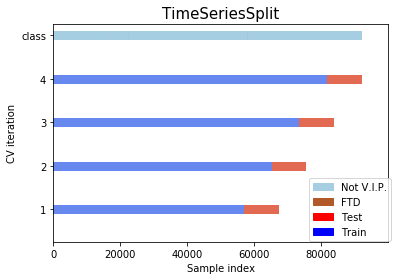

In [17]:
import time
import mpld3
from IPython import display
import six
%matplotlib inline

n_splits = 10
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(max_train_size=None, n_splits=n_splits)
print(tscv)
inds = tscv.split(X_train)
train_idx = []
test_idx = []
for train_index, test_index in tscv.split(X_train):
    train_idx.append(train_index)
    test_idx.append(test_index)

cv_dataset = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_indices)
idx = []        
for i in range(5):
    idx.append([train_idx[0-i],test_idx[0-i]])
print(idx[0])  

fig, ax = plt.subplots()
_=plot_cv_indices(tscv, X_train, y_train, ax, n_splits,9)
_=ax.set_ylim(5.75,10.75)
_=ax.set_yticklabels(["","","","","","",1,2,3,4,"class"])




legend_elements = [Patch(facecolor=[0.65098039, 0.80784314, 0.89019608, 1.],
                         edgecolor=[0.65098039, 0.80784314, 0.89019608, 1.],
                         label='Not V.I.P.'),
                   Patch(facecolor=[0.69411765, 0.34901961, 0.15686275, 1.],
                         edgecolor=[0.69411765, 0.34901961, 0.15686275, 1.],
                         label='FTD'),
                  Patch(facecolor=[1,0,0,1],
                         edgecolor=[1,0,0,1], 
                         label='Test'),
                   Patch(facecolor=[0, 0, 1],
                         edgecolor=[0, 0, 1],
                         label='Train')]

_=ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(.75, 0.15))
plt.savefig('Cross validaion sections for hyperparameter search')

In [18]:
model = CatBoostClassifier(loss_function='Logloss',task_type="GPU")

grid = {'learning_rate': [0.03, 0.1,0.3],
        'depth': [1, 4, 6, 12, 16],
        'l2_leaf_reg': [1, 3, 5, 7, 9,11,13,15],
        'iterations' : [1,10,100,1000,3000],
        'bagging_temperature': [0,0.25,0.5,0.75,1,1.5,2,3,4]}



grid_search_result = model.grid_search(grid, 
                                        cv_dataset, 
                                        cv=idx,
                                        partition_random_seed=0,
                                        calc_cv_statistics=True,
                                        search_by_train_test_split=True,
                                        refit=True,
                                        shuffle=False,
                                        stratified=None,
                                        verbose=True)


0:	loss: 0.6047605	best: 0.6047605 (0)	total: 995ms	remaining: 1h 29m 30s
1:	loss: 0.4315219	best: 0.4315219 (1)	total: 2.09s	remaining: 1h 33m 55s
2:	loss: 0.1484377	best: 0.1484377 (2)	total: 3.05s	remaining: 1h 31m 22s
3:	loss: 0.6047609	best: 0.1484377 (2)	total: 3.77s	remaining: 1h 24m 49s
4:	loss: 0.4315231	best: 0.1484377 (2)	total: 4.56s	remaining: 1h 21m 56s
5:	loss: 0.1484392	best: 0.1484377 (2)	total: 5.22s	remaining: 1h 18m 9s
6:	loss: 0.6048636	best: 0.1484377 (2)	total: 5.87s	remaining: 1h 15m 19s
7:	loss: 0.4317792	best: 0.1484377 (2)	total: 6.55s	remaining: 1h 13m 35s
8:	loss: 0.1487091	best: 0.1484377 (2)	total: 7.22s	remaining: 1h 12m 4s
9:	loss: 0.6048644	best: 0.1484377 (2)	total: 7.93s	remaining: 1h 11m 12s
10:	loss: 0.4317819	best: 0.1484377 (2)	total: 8.6s	remaining: 1h 10m 14s
11:	loss: 0.1487162	best: 0.1484377 (2)	total: 9.26s	remaining: 1h 9m 18s
12:	loss: 0.6048649	best: 0.1484377 (2)	total: 9.94s	remaining: 1h 8m 38s
13:	loss: 0.4317837	best: 0.1484377 (2)	

109:	loss: 0.0122219	best: 0.0121902 (98)	total: 14m 23s	remaining: 11h 32m
110:	loss: 0.0122117	best: 0.0121902 (98)	total: 15m 1s	remaining: 11h 56m 9s
111:	loss: 0.0122131	best: 0.0121902 (98)	total: 15m 34s	remaining: 12h 15m 33s
112:	loss: 0.0122186	best: 0.0121902 (98)	total: 16m 11s	remaining: 12h 37m 41s
113:	loss: 0.0122200	best: 0.0121902 (98)	total: 16m 48s	remaining: 12h 59m 6s
114:	loss: 0.0122047	best: 0.0121902 (98)	total: 17m 20s	remaining: 13h 16m 54s
115:	loss: 0.0122176	best: 0.0121902 (98)	total: 17m 55s	remaining: 13h 36m 42s
116:	loss: 0.0122516	best: 0.0121902 (98)	total: 18m 31s	remaining: 13h 56m 14s
117:	loss: 0.0121938	best: 0.0121902 (98)	total: 19m 3s	remaining: 14h 13m 12s
118:	loss: 0.0122062	best: 0.0121902 (98)	total: 19m 36s	remaining: 14h 30m 29s
119:	loss: 0.0122040	best: 0.0121902 (98)	total: 20m 13s	remaining: 14h 49m 39s
120:	loss: 0.5952684	best: 0.0121902 (98)	total: 20m 13s	remaining: 14h 42m 37s
121:	loss: 0.4076153	best: 0.0121902 (98)	total:

212:	loss: 0.0121456	best: 0.0115605 (173)	total: 29m 10s	remaining: 11h 50m 16s
213:	loss: 0.0123165	best: 0.0115605 (173)	total: 29m 30s	remaining: 11h 55m 17s
214:	loss: 0.0119335	best: 0.0115605 (173)	total: 29m 51s	remaining: 12h 11s
215:	loss: 0.0119897	best: 0.0115605 (173)	total: 30m 13s	remaining: 12h 5m 31s
216:	loss: 0.0119818	best: 0.0115605 (173)	total: 31m 17s	remaining: 12h 27m 24s
217:	loss: 0.0119917	best: 0.0115605 (173)	total: 32m 21s	remaining: 12h 49m 9s
218:	loss: 0.0124638	best: 0.0115605 (173)	total: 33m 26s	remaining: 13h 10m 58s
219:	loss: 0.0119971	best: 0.0115605 (173)	total: 34m 29s	remaining: 13h 32m 5s
220:	loss: 0.0120473	best: 0.0115605 (173)	total: 35m 33s	remaining: 13h 53m 11s
221:	loss: 0.0120476	best: 0.0115605 (173)	total: 36m 37s	remaining: 14h 14m 17s
222:	loss: 0.0119787	best: 0.0115605 (173)	total: 37m 40s	remaining: 14h 34m 46s
223:	loss: 0.0119860	best: 0.0115605 (173)	total: 38m 44s	remaining: 14h 55m 1s
224:	loss: 0.0119905	best: 0.0115605

KeyboardInterrupt: 

In [19]:
Res_df = pd.DataFrame(grid_search_result['cv_results'])

Res_df.sort_values(by='test-Logloss-mean', ascending=True, inplace=True)
Res_df.head()

NameError: name 'grid_search_result' is not defined

In [ ]:
print("Best Params : ")
grid_search_result['params']

In [ ]:

                
model = CatBoostClassifier(iterations=grid_search_result['params']['iterations'],
           loss_function= 'Logloss',
           l2_leaf_reg=grid_search_result['params']['l2_leaf_reg'],
           depth=grid_search_result['params']['depth'],
           learning_rate=grid_search_result['params']['learning_rate'],
           verbose=False,
           custom_metric=['AUC','Precision','Recall'],
           task_type="GPU")
model.fit(X_train, y_train, cat_features=cat_indices, verbose=False,plot=True,use_best_model=True,
          eval_set=(X_test,y_test));

p_train = model.predict_proba(X_train)[:,1]

p_test = model.predict_proba(X_test)[:,1]

In [ ]:
print("calibration test = "+str(p_test.sum()/ y_test.sum()))
print("calibration train = "+str(p_train.sum() / y_train.sum()))

print(roc_auc_score(y_test, p_test), y_test.mean(), len(y_test))

In [ ]:
F_scores = model.get_feature_importance(Pool(X_test, label=y_test,
                                                  cat_features=cat_indices))
feature_score = pd.DataFrame({'Feature' : all_features, 'Score' : F_scores})
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort',
                                          na_position='last')
_ = [print("%2d. %-50s %.5f" % (i, f[0], f[1])) for i, f in enumerate(feature_score.values) if f[1] >= 1.0]
feature_score.to_csv('/home/octopus/projects/sandbox/easytech/FeatureImportence.csv',index=False)

In [ ]:
eps = 0.1
pbounds = {'threshold': (0 + eps, 0.8 - eps)}
p_train = model.predict(X_train, prediction_type='Probability')[:, 1]
p_test = model.predict(X_test, prediction_type='Probability')[:, 1]
def func(threshold):
    report = classification_report(y_train, p_train > threshold, output_dict=True)
    return -abs(report['1.0']['precision'] - report['1.0']['recall'])
optimizer = BayesianOptimization(
    f=func,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(
    init_points=3,
    n_iter=7,
)
threshold = optimizer.max['params']['threshold']


print("optimized threshold is %f\n" % threshold)
train_report = classification_report(y_train, p_train > threshold, output_dict=True)
validation_report = classification_report(y_test, p_test > threshold, output_dict=True)

print(validation_report)

In [ ]:
%matplotlib inline


train_global_calibration = p_train.sum()/y_train.sum()
validation_global_calibration = p_test.sum()/y_test.sum()




cm = confusion_matrix(y_train, p_train/train_global_calibration > threshold)

fpr, tpr, thresholds = metrics.roc_curve(y_train, p_train, pos_label=1)
train_auc = metrics.auc(fpr, tpr)
validation_auc = roc_auc_score(y_test, p_test)
print("validation AUC : %.4f" % train_auc)
print("validation AUC : %.4f" % validation_auc)

fig,ax = plt.subplots(1,3,figsize = [10,10])
fig.suptitle("Train scores",fontweight='bold',fontsize=16)
fig.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=None, hspace=None)
lw = 2

ax[0].plot(fpr, tpr, color='darkorange',
                    lw=lw, label='ROC curve \n(area = %0.5f\nf1score = %0.3f)' % (train_auc, train_report['0.0']['f1-score']))
ax[0].fill_between(fpr,tpr,color='r',alpha=0.25,label='area under the curve')

ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver operating characteristic\nAUC = %.4f' %(train_auc))
ax[0].legend(loc="lower right")
ax[1].hist(p_train,density=False,bins=np.arange(0,0.6,0.05))
ax[1].set_xlabel('Predictions')




cm = confusion_matrix(y_train, p_train/train_global_calibration > threshold)

cm_norm = cm/cm.astype(np.float).sum(axis=1)
df_cm = pd.DataFrame(cm, index = [i for i in ["Not V.I.P.","V.I.P."]],
              columns = [i for i in ["Not V.I.P.","V.I.P."]])
sn.heatmap(df_cm, annot=True,fmt = 'd',linewidth=0.5,ax=ax[2],cbar=False)
ax[2].set_ylabel("True")
ax[2].set_xlabel("Predited")
plt.savefig('/home/octopus/projects/sandbox/easytech/Predictions_Scores_Train.png')


fpr, tpr, thresholds = metrics.roc_curve(y_test, p_test, pos_label=1)
fig,ax = plt.subplots(1,3,figsize = [10,10])
fig.suptitle("Test scores",fontweight='bold',fontsize=16)
fig.subplots_adjust(left=0.1, bottom=0.1, right=1.0, top=0.9, wspace=None, hspace=None)
lw = 2

ax[0].plot(fpr, tpr, color='darkorange',
                    lw=lw, label='ROC curve \n(area = %0.5f\nf1score = %0.3f)' % (validation_auc, validation_report['0.0']['f1-score']))
ax[0].fill_between(fpr,tpr,color='r',alpha=0.25,label='area under the curve')

ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('Receiver operating characteristic\nAUC = %.4f' %(validation_auc))
ax[0].legend(loc="lower right")
ax[1].hist(p_test,density=False,bins=np.arange(0,0.6,0.05))
ax[1].set_xlabel('Predictions')




cm = confusion_matrix(y_test, p_test/train_global_calibration > threshold)
cm_norm = cm/cm.astype(np.float).sum(axis=1)
df_cm = pd.DataFrame(cm, index = [i for i in ["No Deposit","Deposit"]],
              columns = [i for i in ["No Deposit","Deposit"]])
sn.heatmap(df_cm, annot=True,fmt = 'd',linewidth=0.5,ax=ax[2],cbar=False)
ax[2].set_ylabel("True")
ax[2].set_xlabel("Predited")
plt.savefig('/home/octopus/projects/sandbox/easytech/Predictions_Scores_Test.png')

In [ ]:
%matplotlib inline
n = 5
Dp = 100/n
res = pd.DataFrame({'P':p_test,'Y':y_test})
res['P_quantile'] = pd.qcut(res['P'],q=n)
res2 = res.groupby(['P_quantile'])['Y'].sum()
plt.figure()
plt.bar(np.arange(0,n),res2.values/np.sum(res.Y),color='b',label='Percent of VIPs in this group')

plt.bar(np.arange(0,n),(res2.values/np.sum(res.Y)).cumsum(),color='g',alpha=0.25,label='Sum percent of FTDs up to this group')
plt.xticks(np.arange(0,n),labels=np.arange(1,11))
ylabels = []
for y in np.arange(0,110,10):
    ylabels.append(str(y)+"%")
plt.yticks(np.arange(0,(100+10)/100,10/100),labels= np.asarray(ylabels))
ax = plt.gca()
ax.set_xlabel("quantile")
ax.set_ylabel('Percent')

plt.grid('both')
_=plt.legend()

plt.savefig('/home/octopus/projects/sandbox/easytech/VIPs_Quantiles.png')